# BikeMi Data

In [39]:
# path manipulation
from pathlib import Path

# data manipulation
import pandas as pd
import geopandas
import numpy as np

# connecting to the local database with the data
import psycopg2

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as cx

# create paths
data_path = Path(Path.cwd().parents[0] / "data")
milan_data = Path(data_path / "milan")

# establish connection with the database
conn = psycopg2.connect("dbname=bikemi user=luca")

## Data Ingestion

The data was made available thanks to a partnership established by Prof. Giancarlo Manzi of the University of Milan and Clear Channel Italia, the provider of the service. The data is comprised of all the individual trips performed by each client (`cliente_anonimizzato`). This includes the bike type (which can either be a regular bike or an electric bike), the bike identifier, the station of departure and arrival with the time, the duration of the trip `durata_noleggio` plus the total travel distance. We do not know how the total travel distance `distanza_totale` is computed.

In [2]:
query = """
    SELECT *
    FROM bikemi_source_data
    LIMIT 5;
"""

pd.read_sql(sql=query, con=conn)

,bici,tipo_bici,cliente_anonimizzato,data_prelievo,numero_stazione_prelievo,nome_stazione_prelievo,data_restituzione,numero_stazione_restituzione,nome_stazione_restituzione,distanza_totale,durata_noleggio
0,8480,Bike,47869,2015-06-30 23:59:31.694000+00:00,103,Arco della Pace 2 - Pagano,2015-07-01 00:07:44.110000+00:00,173,Vercelli - Cherubini,1650.53,0 days 00:08:12
1,6190,Bike,74372,2015-06-30 23:55:43.747000+00:00,39,XXV Aprile,2015-07-01 00:07:53.686000+00:00,115,Caiazzo,2562.41,0 days 00:12:09
2,6000,Bike,105372,2015-06-30 23:54:53.998000+00:00,6,San Giorgio,2015-07-01 00:20:49.352000+00:00,163,Rosario,2401.88,0 days 00:25:55
3,10538,eBike,103840,2015-06-30 23:54:52.672000+00:00,39,XXV Aprile,2015-07-01 00:07:55.198000+00:00,115,Caiazzo,2562.41,0 days 00:13:02
4,1981,Bike,57260,2015-06-30 23:54:03.860000+00:00,39,XXV Aprile,2015-07-01 00:12:17.121000+00:00,63,Sant'Ambrogio,2439.21,0 days 00:18:13


The data available ranges from the first of June, 2015, to the first of October, 2020, totalling to 15.842.891 observations. Data was made available in Excel spreadsheets, following the [Office Open XML SpreadsheetML File Format](https://docs.microsoft.com/en-us/openspecs/office_standards/ms-xlsx/f780b2d6-8252-4074-9fe3-5d7bc4830968) (the `.xlsx` file format). Python's Pandas library has methods to read `.xlsx` files; however, given how big these files are, data manipulation would have proven unfeasible.

For this reason, we resorted to some useful and popular open source tools, which we used to build `bash` scripts and functions to automate conversion from `.xlsx` to `.csv` files, perform some elementary data cleaning and load the data into a local PostgreSQL database. Format conversion to Comma-Separated Values (`.csv`) was performed using [`csvkit`](https://github.com/wireservice/csvkit), a Python package to perform basic operations on `.csv` files from the command line. Being written in Python, `csvkit` can be slow. However, as part of a major trend for several command-line applications, `csvkit` was rewritten in Rust, a fast and secure programming language whose popularity has been rising in the last couple of years <cite id="jf5wt">(Perkel, 2020)</cite>. Much alike Julia <cite id="ge16g">(Perkel, 2019)</cite>, Rust is becoming a tool for data science, as well as scientific computing (for example in bio-statistics) as it is "a language that offer[s] the 'expressiveness' of Python but the speed of languages such as C and C++" <cite id="1xb31">(Perkel, 2020)</cite>.

The Rust port of `csvkit` is called [`xsv`](https://github.com/BurntSushi/xsv), and is blazing fast. Much alike `awk` <cite id="tcloo">(<i>Gawk - GNU Project - Free Software Foundation (FSF)</i>, n.d.)</cite>, `xsv` can perform filtering operations, but also joins and partitions, as well as computing summary statistics. `xsv` does not offer format conversion (yet), but was used to filter out a negligible number of invalid observations from each original `.xslx` files (after the conversion to `.csv`), and select only the columns that would enter the final dataset.

Finally, `psql` (PostgreSQL's command line utility) was used to upload the 'clean' data into a local database instance. PostgreSQL was also used to perform basic survey statistics, like computing the number of rows, and data aggregation (such as counting the number of observations by year). Looking at the frequency tables by year, there appears to be an oddly small number of observations from 2018. This is because there is indeed missing data from June 2018 until the end of the year. For this reason, we chose to work only with data from June 2015 to the end of May 2018.

In [3]:
query = """
    SELECT
        EXTRACT('year' FROM b.data_prelievo) AS date,
        COUNT(b.bici)
    FROM bikemi_source_data b
    -- WHERE EXTRACT('year' FROM b.data_prelievo) < 2019
    GROUP BY EXTRACT('year' FROM b.data_prelievo);
"""

pd.read_sql(sql=query, con=conn).astype("int")

,date,count
0,2015,1971891
1,2016,4066783
2,2017,4272480
3,2018,1457631
4,2019,2830566
5,2020,1243540


## BikeMi Data Analysis

### Finalising Data Selection

In addition to selecting only trips from June 2015 to June 2018, we also disregard all rentals whose duration is smaller than one minute - as previously done in the literature. This leaves us with more than 11,7 million observations. We store these in a [materialised view](https://www.postgresql.org/docs/current/sql-creatematerializedview.html):

In [6]:
query = """
    CREATE MATERIALIZED VIEW IF NOT EXISTS bikemi_rentals AS (
        SELECT
            b.tipo_bici,
            b.cliente_anonimizzato,
            DATE_TRUNC('second', b.data_prelievo) AS data_prelievo,
            b.numero_stazione_prelievo,
            b.nome_stazione_prelievo,
            DATE_TRUNC('second', b.data_restituzione) AS data_restituzione,
            b.numero_stazione_restituzione,
            b.nome_stazione_restituzione,
            b.durata_noleggio
        FROM bikemi_source_data b
        WHERE
            EXTRACT('year' FROM b.data_restituzione) < 2019 AND
            durata_noleggio > interval '1 minute'
    );
"""

### Top Users and Commuting Habits

In [6]:
query = """
    SELECT
        COUNT(DISTINCT cliente_anonimizzato)
    FROM bikemi_rentals;
    """

pd.read_sql(query, conn)

,count
0,192431


The service has almost 200 thousands unique subscribers in the time period. Then breakdown by year is the following:

In [28]:
query = """
    SELECT
        EXTRACT('year' FROM data_prelievo) AS anno,
        COUNT(DISTINCT cliente_anonimizzato)
    FROM bikemi_rentals
    GROUP BY EXTRACT('year' FROM data_prelievo);
    """

pd.read_sql(query, conn).astype({"anno": "int"}).set_index("anno")

,count
anno,
2015,64079
2016,93239
2017,95931
2018,50860


The number of subscriptions is declining in 2015 and 2018, as there are observations for six months only. In particular, for the year 2018 the count is even lower because the autumn/winter months are missing.

It is also interesting to look at the top users:

In [29]:
query = """
    SELECT
        cliente_anonimizzato,
        COUNT(*) AS noleggi_totali
    FROM bikemi_rentals b
    GROUP BY
        cliente_anonimizzato
    ORDER BY noleggi_totali DESC
"""

users_ranking = pd.read_sql(query, conn).set_index("cliente_anonimizzato")

users_ranking.head(10)

,noleggi_totali
cliente_anonimizzato,
40585,3689
19515,2859
38603,2747
43969,2736
23891,2636
15912,2565
56496,2456
17683,2451
42815,2451


But it might be of greater interest to look at the distribution by year:

In [30]:
query = """
    SELECT
        cliente_anonimizzato,
        COUNT(*) AS noleggi_totali,
        EXTRACT('year' FROM data_prelievo) AS anno
    FROM bikemi_rentals b
    GROUP BY
        cliente_anonimizzato,
        EXTRACT('year' FROM data_prelievo)
    ORDER BY noleggi_totali DESC
"""

pd.read_sql(query, conn).astype({"anno": "int"}).head(10).set_index("cliente_anonimizzato")

,noleggi_totali,anno
cliente_anonimizzato,,
43969,1478,2017
146640,1355,2017
40585,1290,2017
40585,1263,2016
188391,1133,2017
165664,1056,2016
147597,1042,2016
19515,1039,2017
97713,1025,2017


As expected, there are more observations from the years 2016 and 2017 as these are complete years. The great number of usage translates to an average of almost 4 trips per day - i.e., to reach the first train station and then the workplace.

### Usage Patterns and Origin-Destination Matrix

As a starter, it is useful to look at the origin-destination (OD) matrix, to see which are the most popular starting and departure points. On the aggregate level, the most popular points on the OD matrix are the train stations and sightseeing places such as Duomo.

In [12]:
top_departure_stations_query = """
    SELECT
        nome_stazione_prelievo,
        COUNT(*) AS numero_noleggi
    FROM bikemi_rentals
    GROUP BY
        nome_stazione_prelievo
    ORDER BY numero_noleggi DESC;
"""

top_departure_stations = pd.read_sql(top_departure_stations_query, conn)

top_arrival_stations_query = """
    SELECT
        nome_stazione_restituzione,
        COUNT(*) AS numero_noleggi
    FROM bikemi_rentals
    GROUP BY
        nome_stazione_restituzione
    ORDER BY numero_noleggi DESC;
"""

top_arrival_stations = pd.read_sql(top_arrival_stations_query, conn)

pd.concat([top_departure_stations, top_arrival_stations], axis=1).head(10)

,nome_stazione_prelievo,numero_noleggi,nome_stazione_restituzione,numero_noleggi
0,Cadorna 3,234694,Cadorna 3,234349
1,Duomo,197573,Duomo,202773
2,Moscova,139561,Moscova,140552
3,Garibaldi - Sturzo,134243,Garibaldi - Sturzo,129611
4,San Babila - RIMOSSA-,128261,XXV Aprile,129006
5,XXV Aprile,127804,San Babila - RIMOSSA-,127974
6,Cadorna 1,118692,Cairoli,113104
7,Cairoli,108717,Palazzo Marino,103253
8,Centrale 1,107864,Cadorna 1,102102
9,Coni Zugna Solari,99152,Cavour,98083


The ranking is basically unchanged if we look only at data from Monday to Friday and within "core" commuting hours (say, from 7 to 10 and from 17 to 20). However, trips towards stations become more frequent and destinations such as Moscova are slightly less popular. Indeed, employees might straight bike to Moscova after work to take a sip from their Negroni.

In [13]:
top_departure_stations_query = """
    SELECT
        nome_stazione_prelievo,
        COUNT(*) AS numero_noleggi
    FROM bikemi_rentals
    WHERE
        EXTRACT('dow' FROM data_restituzione) BETWEEN 0 AND 4 AND
        EXTRACT('hour' FROM data_restituzione) BETWEEN 7 AND 10 OR
        EXTRACT('hour' FROM data_restituzione) BETWEEN 17 AND 20
    GROUP BY
        nome_stazione_prelievo
    ORDER BY numero_noleggi DESC;
"""

top_departure_stations = pd.read_sql(top_departure_stations_query, conn)

top_arrival_stations_query = """
    SELECT
        nome_stazione_restituzione,
        COUNT(*) AS numero_noleggi
    FROM bikemi_rentals
    WHERE
        EXTRACT('dow' FROM data_restituzione) BETWEEN 0 AND 4 AND
        EXTRACT('hour' FROM data_restituzione) BETWEEN 7 AND 10 OR
        EXTRACT('hour' FROM data_restituzione) BETWEEN 17 AND 20
    GROUP BY
        nome_stazione_restituzione
    ORDER BY numero_noleggi DESC;
"""

top_arrival_stations = pd.read_sql(top_arrival_stations_query, conn)

pd.concat([top_departure_stations, top_arrival_stations], axis=1).head(10)

,nome_stazione_prelievo,numero_noleggi,nome_stazione_restituzione,numero_noleggi
0,Cadorna 3,154856,Cadorna 3,157743
1,Duomo,97855,Duomo,109367
2,Garibaldi - Sturzo,83464,Garibaldi - Sturzo,80515
3,Cadorna 1,78254,Moscova,72430
4,Centrale 1,70969,XXV Aprile,69252
5,Moscova,68224,Cadorna 1,66736
6,San Babila - RIMOSSA-,65560,San Babila - RIMOSSA-,66061
7,XXV Aprile,62878,Palazzo Marino,58936
8,Cairoli,58067,Cairoli,58292
9,Palazzo Marino,55740,Centrale 1,56000


The behaviour changes if we look ad the individual trips, i.e. if we `GROUP BY` both departure and destination stations (`nome_stazione_prelievo` and `nome_stazione_restituzione`). To be exact, `Coni Zugna Solari` is close to both the station in Porta Genova as well as the Navigli and Darsena, which partly explains its popularity.

In [14]:
query = """
    SELECT
        nome_stazione_prelievo,
        numero_stazione_prelievo,
        nome_stazione_restituzione,
        numero_stazione_restituzione,
        COUNT(*) AS numero_noleggi
    FROM bikemi_rentals
    GROUP BY
        nome_stazione_prelievo,
        numero_stazione_prelievo,
        nome_stazione_restituzione,
        numero_stazione_restituzione
    ORDER BY numero_noleggi DESC;
"""

trips_rankings = pd.read_sql(query, conn)

trips_rankings.head(10)

,nome_stazione_prelievo,numero_stazione_prelievo,nome_stazione_restituzione,numero_stazione_restituzione,numero_noleggi
0,Coni Zugna Solari,161,Napoli - Washington,172,14144
1,Napoli - Washington,172,Coni Zugna Solari,161,13256
2,Cadorna 3,94,Duomo,1,9363
3,Duomo,1,Cadorna 3,94,8903
4,Coni Zugna Solari,161,Savona - Tolstoj,165,8217
5,Palazzo Marino,100,Cadorna 3,94,7436
6,Bertarelli,65,Cadorna 3,94,6967
7,Vercelli - Piemonte,174,Roncaglia - Washington,157,6373
8,Piola,162,Gorini - Strambio,159,6336
9,Cadorna 3,94,Arcivescovado,102,6197


The same considerations apply when looking at the commuting hours:

In [15]:
query = """
    SELECT
        nome_stazione_prelievo,
        numero_stazione_prelievo,
        nome_stazione_restituzione,
        numero_stazione_restituzione,
        COUNT(*) AS numero_noleggi
    FROM bikemi_rentals
    WHERE
        EXTRACT('dow' FROM data_restituzione) BETWEEN 0 AND 4 AND
        EXTRACT('hour' FROM data_restituzione) BETWEEN 7 AND 10 OR
        EXTRACT('hour' FROM data_restituzione) BETWEEN 17 AND 20
    GROUP BY
        nome_stazione_prelievo,
        numero_stazione_prelievo,
        nome_stazione_restituzione,
        numero_stazione_restituzione
    ORDER BY numero_noleggi DESC;
"""

trips_rankings_commuting_hours = pd.read_sql(query, conn)

trips_rankings_commuting_hours.head(10)

,nome_stazione_prelievo,numero_stazione_prelievo,nome_stazione_restituzione,numero_stazione_restituzione,numero_noleggi
0,Coni Zugna Solari,161,Napoli - Washington,172,8641
1,Napoli - Washington,172,Coni Zugna Solari,161,8317
2,Cadorna 3,94,Duomo,1,6247
3,Palazzo Marino,100,Cadorna 3,94,6063
4,Bertarelli,65,Cadorna 3,94,5725
5,Coni Zugna Solari,161,Savona - Tolstoj,165,5400
6,Duomo,1,Cadorna 3,94,4844
7,Cadorna 3,94,Arcivescovado,102,4369
8,Cadorna 3,94,Bergognone - Tortona,164,4223
9,Cadorna 3,94,Palazzo Marino,100,4162


This reinforces the conclusion that BikeMi is consistently used for commuting purposes. However, this data can be better explored including its spatial representation.

## Spatial Data Operations

On its open data portal, the Comune di Milano publishes all sorts of open data - like the daily entrances in the so-called Area C, where access to private cars is limited. On this treasure trove of data, we can also find things like the location of column fountains and newsstands, but also the geo-referenced data of bike tracks and the location of [BikeMi Stations](https://dati.comune.milano.it/it/dataset/ds65_infogeo_aree_sosta_bike_sharing_localizzazione_). As noted previously, the service has some 320 stations, spread unevenly across the town, as it was outlined by previous studies <cite id="tfga6">(Saibene &#38; Manzi, 2015)</cite>. As a starter, we filter out all stations that have been introduced after 2019. This leaves us with 281 official stations, versus 279 in the historic data.

In [23]:
bikemi_stalls = (
    geopandas.read_file(Path(milan_data / "bikemi-stalls.geojson"))
    .filter(["numero", "nome", "zd_attuale", "anno", "geometry"])
    .rename(columns={"numero": "numero_stazione", "zd_attuale": "municipio" })
    .set_index("numero_stazione")
    .query("anno < 2019")
    .astype({"anno": "int"})
)

# bikemi_stalls.to_csv(Path(milan_data / "bikemi-stalls.csv"))

bikemi_stalls.head()

,nome,municipio,anno,geometry
numero_stazione,,,,
001,Duomo,1,2008,POINT (9.18914 45.46475)
402,San Babila Bis,1,2008,POINT (9.19725 45.46627)
003,Cadorna 1,1,2008,POINT (9.17566 45.46800)
004,Lanza,1,2008,POINT (9.18197 45.47227)
005,Universita' Cattolica,1,2008,POINT (9.17641 45.46312)


The data is represented with the (geographic) coordinate reference system (CRS) `EPSG:4326`, but in order to use the `contextily` library we need to cast it to the (projected) reference system `EPSG:3587`. As the map shows, the stalls stretch to the North, towards Bicocca and Sesto San Giovanni. We can already see that the stalls distribution outside the city centre follows bike lanes (in blue).

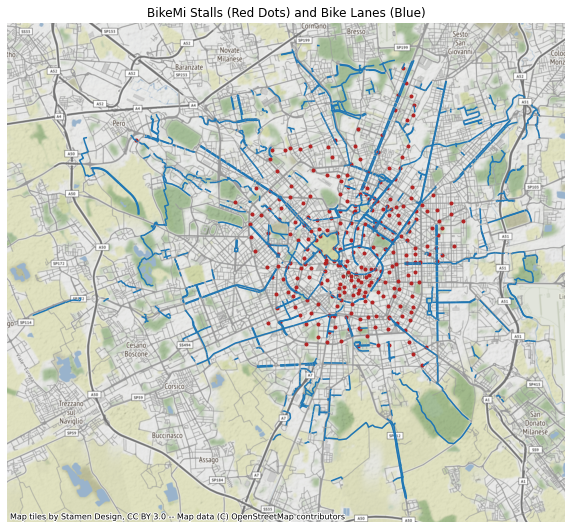

In [3]:
bike_lanes = geopandas.read_file(Path(milan_data / "transports-bike_lanes.geojson"))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

bikemi_stalls.to_crs(3857).plot(ax=ax, c="firebrick", marker=".")
bike_lanes.to_crs(3857).plot(ax=ax)
cx.add_basemap(ax)

plt.axis("off")

plt.title("BikeMi Stalls (Red Dots) and Bike Lanes (Blue)")

plt.show()

The stalls in the outer stations are not as used as the ones in the city centre. Some are practically unused, or display low variance. Besides, the great count of stations would represent a problem in the context of multivariate regressions (the so-called $p > n$ problem). Hence, we need to come up with a criteria to reduce the number of stations. We create another two `materialised views` with the daily and hourly rentals, by station. If we simply were to `GROUP BY` station names and time units, we would obtain series with gaps in the time index. We first create a table with all possible combinations of stations and dates using a `CROSS JOIN` and a common table expression (or `CTE`), then left join on this table the values obtained via the `GROUP BY` on the reference table. A similar query is used to obtain the hourly rentals, with hourly time intervals instead of daily ones. 

In [32]:
# query with cross join used to create the second materialised view
# another similar one is used to create the view for hourly observations
materialised_view_daily_rentals = """
    WITH cross_table AS (SELECT
        d.date AS data_partenza,
        s.nome AS stazione_partenza,
        s.numero_stazione
    FROM bikemi_stalls s
    CROSS JOIN (
       SELECT generate_series (timestamp '2015-06-01'
                             , timestamp '2018-06-01'
                             , interval  '1 day')::date
       ) d(date)
    ORDER BY nome, date ASC)

    SELECT
        c.data_partenza,
        c.stazione_partenza,
        c.numero_stazione,
        COUNT(b.*) AS noleggi_giornalieri
    FROM cross_table c
    LEFT JOIN bikemi_rentals b
        ON b.numero_stazione_prelievo = c.numero_stazione
        AND DATE_TRUNC('day', b.data_prelievo)::date = c.data_partenza
    GROUP BY
        c.data_partenza,
        c.stazione_partenza,
        c.numero_stazione
    ORDER BY stazione_partenza, data_partenza ASC;
"""

retrieve_daily_rentals = """
    SELECT * FROM daily_rentals;
"""

daily_rentals = pd.read_sql(retrieve_daily_rentals, conn).set_index("data_partenza")

We then proceed to analyse the missing values, broken down by station.

In [85]:
obs_number = daily_rentals.index.unique().shape[0]

stations_missing_obs = (
    daily_rentals[[col for col in daily_rentals.columns if "numero_stazione" not in col]]
    .pivot(columns="stazione_partenza")
    .replace(0, np.nan)
    .isna().sum()
    .sort_values(ascending=False)
    .pipe(pd.DataFrame)
    # drop the redundant index
    .droplevel(0)
    .rename({0: "missing_values"}, axis=1)
    # create the % by dividing the number of missing values by the length of the datetime idnex
    .assign(pct_missing=lambda x: x.missing_values / obs_number)
)

# labels for the categorical variable, assumed to be ascending order
labels = ["very_low", "low", "average", "high", "very_high"]

stations_missing_obs["missing_obs_ranking"] = pd.cut(
    stations_missing_obs["pct_missing"], bins=5, labels=labels
)

stations_missing_obs.missing_obs_ranking.plot(kind="hist")

TypeError: no numeric data to plot

In [79]:
daily_rentals.index.unique().shape[0]

1097

Previously, authors have chosen to analyse just the area inside the Bastioni, or "Area C" <cite id="sopwq">(Saibene &#38; Manzi, 2015)</cite>. This choice seems restricting, as it leaves out most of the train stations. For the purpose of our analysis, even given the limitations in the available data, it would be better to widen the range. The following map depicts the distribution of train and metro stations that fall within the city of Milan, shaded in blue:

In [18]:
metro_stations = geopandas.read_file(Path(milan_data / "transports-metro_stops.geojson"))

# train_stations = geopandas.read_file(Path(milan_data / "transports-train_stations.zip"))
# train_stations.to_file("../data/milan/milan-transports-train_stations.geojson", driver="GeoJSON")

train_stations = geopandas.read_file(Path(milan_data / "transports-train_stations.geojson"))

municipi = (
    geopandas
    .read_file(Path(milan_data / "administrative-municipi.geojson"))
    .rename(str.lower, axis=1)
    .filter(["geometry", "municipio"])
)

nil = (
    geopandas
    .read_file(Path(milan_data / "administrative-nil.geojson"))
    .rename(str.lower, axis=1)
    .filter(["id_nil", "nil", "geometry"])
)

milan = municipi.dissolve().rename({"municipio": "milano"}, axis=1)

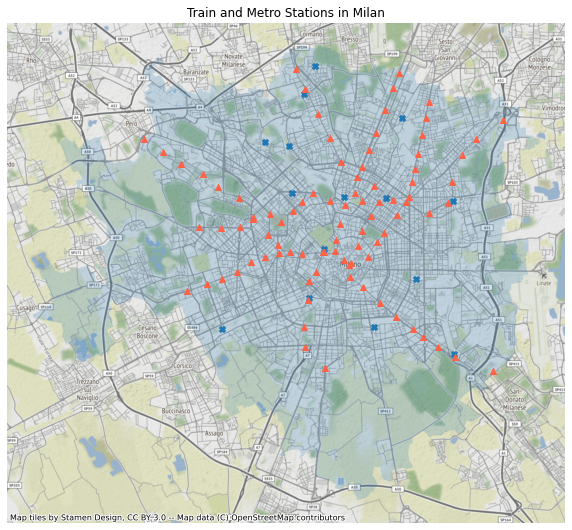

In [19]:
milan_train_stations = train_stations.to_crs(4326).sjoin(milan)
milan_metro_stations = metro_stations.sjoin(milan)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nil.to_crs(3857).plot(ax=ax, alpha=0.2)
milan_train_stations.to_crs(3857).plot(ax=ax, marker="X")
milan_metro_stations.to_crs(3857).plot(ax=ax, marker="^", c="tomato")
cx.add_basemap(ax)

plt.axis("off")

plt.title("Train and Metro Stations in Milan")

plt.show()

To avoid taking too many stations in, we choose to work only with those that fall inside the ring that encapsulates Milan. This is arguably limiting, as the area does not take in Lambrate and Villapizzone/Bovisa train stations. However, one might argue that it is unlikely for to choose to go to Lambrate and then rent a bike to get to the city centre, as they can just get to Centrale; the same goes for the other stations. In other words, this area contains the sufficient amount of stations to provide a useful forecast for the policymaker, albeit neglecting the outer stalls. This reinforces the bias towards the centre of the city, but given the technical constraints seems to be the more viable option. However, as a comparison, the Area C would only contain one train station, whereas this area contains all of the top rentals stalls from the origin-destination (OD) matrix.

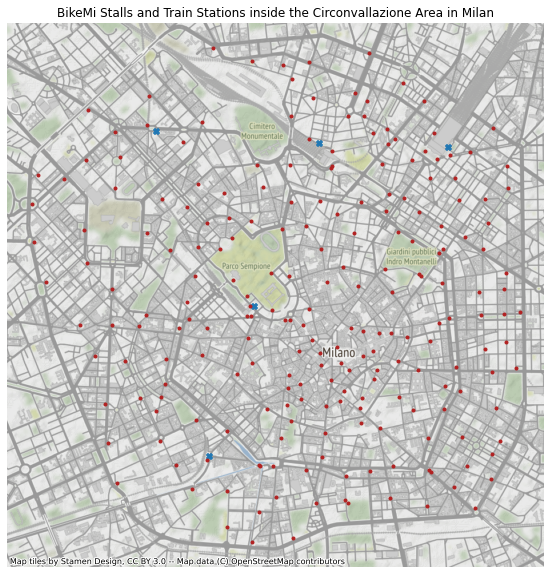

In [21]:
area_circonvallazione = geopandas.read_file(Path(milan_data / "custom-area_circonvallazione.geojson"))
train_stations_circ = train_stations.to_crs(4326).sjoin(area_circonvallazione)
bikemi_stalls_circ = bikemi_stalls.sjoin(area_circonvallazione)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

train_stations_circ.to_crs(3857).plot(ax=ax, marker="X")
bikemi_stalls_circ.to_crs(3857).plot(ax=ax, c='firebrick', marker=".")
cx.add_basemap(ax)

plt.axis("off")

plt.title("BikeMi Stalls and Train Stations inside the Circonvallazione Area in Milan")

plt.show()

## Retrieve Data Aggregated at Station-Level

In [9]:
# when the station_columns is specified, data for each station is retrieved
station_daily_outflow = (
    rf.retrieve_bike_flow(
        table="bikemi_2019",
        station_column=["nome_stazione_prelievo", "stazione_partenza"],
    )
    # it's easier if we don't pivot to wider immediately
    # .pipe(rf.pivot_bike_flow, cols="stazione_partenza")
    # .fillna(0) later
    .convert_dtypes().sort_values(  # make double into integers
        by=["giorno_partenza", "stazione_partenza"], ascending=False
    )
)

station_daily_outflow.tail()

,stazione_partenza,count
giorno_partenza,,
2019-01-01,Angilberto - Comacchio,2
2019-01-01,Amendola M1,2
2019-01-01,Alserio - Cola Montano,7
2019-01-01,Adamello - Lorenzini,1
2019-01-01,Accursio - Portello,2


At first glance, there appears to be quite a few missing values. We also need to get rid of the January 2020 data:

In [10]:
station_daily_outflow = station_daily_outflow.loc[
    station_daily_outflow.index != "2020-01-01"
]

Then we look into the missing data:

In [11]:
station_wide = station_daily_outflow.pivot(columns="stazione_partenza")

In [12]:
station_missing_obs = (
    station_wide.isnull()
    .sum()
    .reset_index()
    .rename(columns={"index": "station_name", 0: "missing_obs"})
)

station_missing_obs.head()

,level_0,stazione_partenza,missing_obs
0,count,Accursio - Portello,2
1,count,Adamello - Lorenzini,4
2,count,Alserio - Cola Montano,0
3,count,Amendola M1,3
4,count,Angilberto - Comacchio,40


In [13]:
station_missing_obs["pct_missing"] = station_missing_obs["missing_obs"] / 366 * 100

station_missing_obs.sort_values("pct_missing", ascending=False).head(10)

,level_0,stazione_partenza,missing_obs,pct_missing
75,count,Ciceri Visconti - Martini,348,95.081967
275,count,Tertulliano - Caroncini,346,94.535519
209,count,Primaticcio - Legioni Romane,322,87.978142
208,count,Primaticcio - Corba,290,79.234973
103,count,Duomo 2 - Foscolo,276,75.409836
38,count,Bottini 2 - Lambrate M2,272,74.316940
261,count,Soderini - Provincia di Milano,271,74.043716
63,count,Carlini - Dalviano,268,73.224044
37,count,Bottini 1 - Lambrate M2,267,72.950820
234,count,San Gimignano - Tuberose,267,72.950820


This shows - as expected - that some stations are basically not used at all, while some others are quite popular. Let's try to categorise them:

In [14]:
labels = ["very_high", "high", "average", "low", "very_low"]

station_missing_obs["usage_ranking"] = pd.cut(
    station_missing_obs["pct_missing"], bins=5, labels=labels
)

`pd.cut()` will always return a `category` `dtype`. These can also be further manipulated via [`pandas.DataFrame.cat.set_categories()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.set_categories.html) (works with `pandas.Index` and `pandas.DataFrame` too.)

We can tabulate and plot this data:

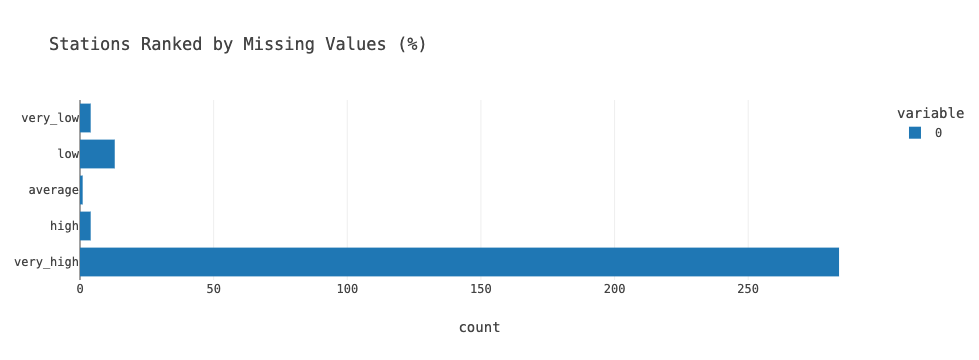

In [16]:
# `.size()` counts the number of member in each category
fig = (
    station_missing_obs.groupby("usage_ranking")
    .size()
    .plot(
        kind="barh",
        template="none",
        labels=dict(value="count", usage_ranking=""),
        title="Stations Ranked by Missing Values (%)",
    )
)

ps.plotly_style(fig)

fig.show()

Before saving the data to a `.csv` file, we should replace the missing observations with `0`:

In [17]:
station_daily_outflow.fillna(0).to_csv("../data/bikemi_csv/station_daily_outflow.csv")

We don't need to save the wide `DataFrame` too, as we can pivot the table with ease.

## Hourly Data

We could also extract hourly data, but we argued it will be noisy:

In [18]:
# we can also extract the hourly data at the aggregate level:
hourly_outflow = rf.retrieve_bike_flow(table="bikemi_2019", trunc="hour")

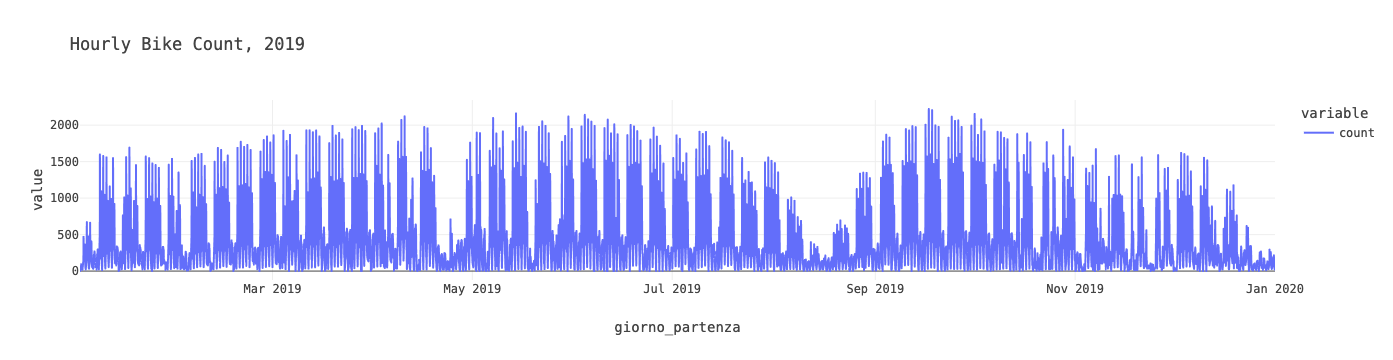

In [20]:
ps.plotly_style(hourly_outflow.plot(title="Hourly Bike Count, 2019"))